A back of the envelope calculation of $\overline{\nu_e}$ flux uncertainties assuming
1. No systematics
2. High number of observed counts
3. Constant reactor power
4. background and signal are not correlated
5. background can be measured with reactor off
6. we aren't squeamish about a Bayesian approach

First, import the necessary packages:

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate

plt.rcParams ['figure.dpi'] = 150

verbose = True


Let's start with the familiar probability for a counting problem, the Poisson distribution:
$$p\left( n; \lambda \right) = \left(\frac{\lambda^n e^{-\lambda}}{n!}  \right)$$

where:
$n$ is the number of counts measured and 
$\lambda$ is the expected number of counts. 

let's put this all in terms of rate instead of counts to save ourselves some headaches later

$\lambda = rt$ where r is the rate and t is the time of measurement 

$$p\left( n; r, t \right) = \left(\frac{(rt)^n e^{-rt}}{n!}  \right)$$

We can use this to calculate the probability of observing a certain number of counts given a expected mean number of counts.  We can also use this to calculate the mean number of counts given a certain number of counts.  This is the likelihood function, and it is the basis for our statistical analysis.

I expect that we will be dealing with $n>>1$.  In this case we can use the gaussian approximation to the poisson distribution:
$$p\left( n; r, t \right) = \left(\frac{(rt)^n e^{-rt}}{n!}  \right) \approx \frac{t}{\sqrt{2\pi rt}}\exp{\left(-\frac{(n-rt)^2}{2rt}\right)}$$

Since we are trying to measure $r$ given a series of observations, having $rt$ = variance in the normal distribution is a bit pesky when performing maximum likelihood estimates, so we will use the estimator $\hat{r} = n/t$ instead which also requires $n>>1$ 

$$L\left( r | n ,t \right) \approx \frac{t}{\sqrt{2\pi n}}\exp{\left(-\frac{(n-rt)^2}{2n}\right)}$$

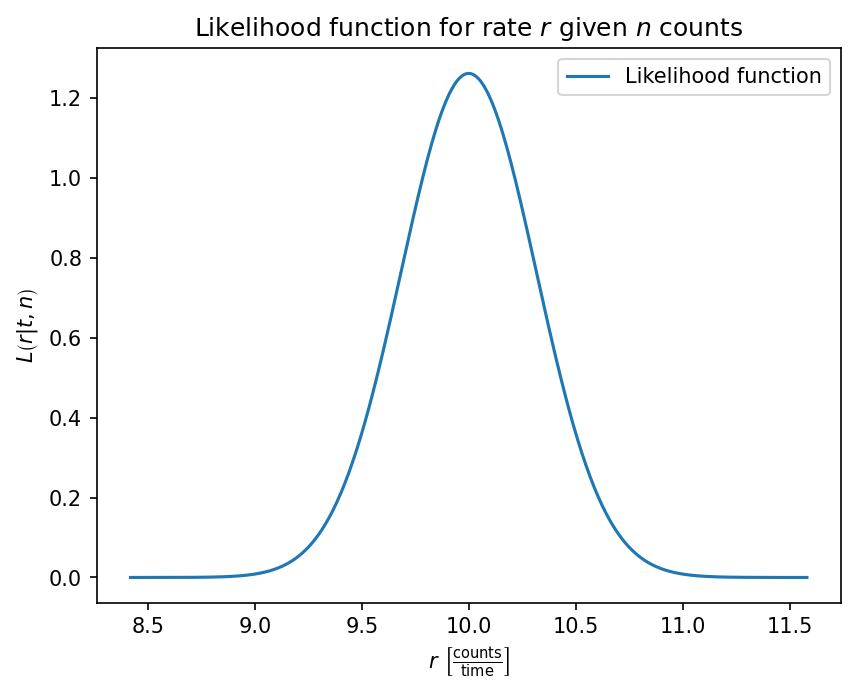

0.9999994261993681


In [2]:
def rate_likelihood(rate, n, time):
    #likelihood for rate given time and counts
    #rate is the rate of the poisson distribution
    #time is the time of measurement
    #n is the number of counts observed over the entire measurement
    if n<100:
        return np.array( time * (rate * time) ** n * np.exp(-(rate* time)) / math.factorial(n),np.float64)
    else:
        return time * np.exp(-(n-(rate * time)) ** 2 /(2 * n)) / np.sqrt(2 * np.pi * n)
    
if verbose:
    counts = 1000
    time = 100

    if -5*np.sqrt(counts)+counts < 0:
        lowerbound = 0
    else:
        lowerbound = (-5*np.sqrt(counts) + counts)/time
        
    p_mu = np.linspace(lowerbound,(counts+5*np.sqrt(counts))/time, 500)
    likelihood_values = rate_likelihood(p_mu, counts, time)
    # Plot the likelihood function
    plt.plot(p_mu, likelihood_values, label='Likelihood function')

    plt.title(r'$\text{Likelihood function for rate }r \text{ given }n \text{ counts}$')
    plt.xlabel(r'$r ~ \left[\frac{\text{counts}}{\text{time}}\right]$')
    plt.ylabel(r'$L\left(r | t , n\right)$')

    plt.legend()
    plt.show()
    print(np.trapz(likelihood_values,p_mu))

Next we want to calculate the probability of observing a certain number of counts $n_\tau$ given we have some *known expectation* of background and signal:

$\lambda_b$ the true (total) background rate
$\lambda_s$ the true signal rate

I am going to jump straight to the gaussian approximation for the poisson distribution.  Using the [sum of normally distributed variables](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables) we can then write 

the probability of observing $n_\tau$ counts 
$$p\left( n_t; \lambda_b, \lambda_s \right) \approx \frac{1}{\sqrt{2\pi (\lambda_b + \lambda_s)}}\exp{\left(-\frac{(n_t-(\lambda_b+\lambda_s))^2}{2(\lambda_b+\lambda_s)}\right)}$$

making the same replacements to $\lambda$ as above, I put everything in terms of rates

$$p\left( n_\tau; r_b, r_s, t_\tau \right) \approx \frac{t_\tau}{\sqrt{2\pi t_\tau (r_b + r_s)}}\exp{\left(-\frac{(n_\tau-t_\tau(r_b+r_s))^2}{2 t_\tau(r_b+r_s)}\right)}$$

right now this isn't anything special, it looks like we just set $n = n_\tau$ and $r = r_b + r_s$ on our gaussian for $p\left(n;r,t\right)$ from earlier.

However, we do not have $r_b$ and $r_s$ as known parameters.  We have to estimate them from our data.  We write the likelihood function for the true rates $r_b$ and $r_s$ given our observed counts $n_\tau$ (using a similar approximation for the estimator $\hat{r} = n/t$)


$$L\left( r_b, r_s | n_\tau , t_\tau \right) \approx \frac{t_\tau}{\sqrt{2\pi n_\tau}} \exp{\left(-\frac{(n_\tau-t_\tau(r_b+r_s))^2}{2n_\tau}\right)}$$


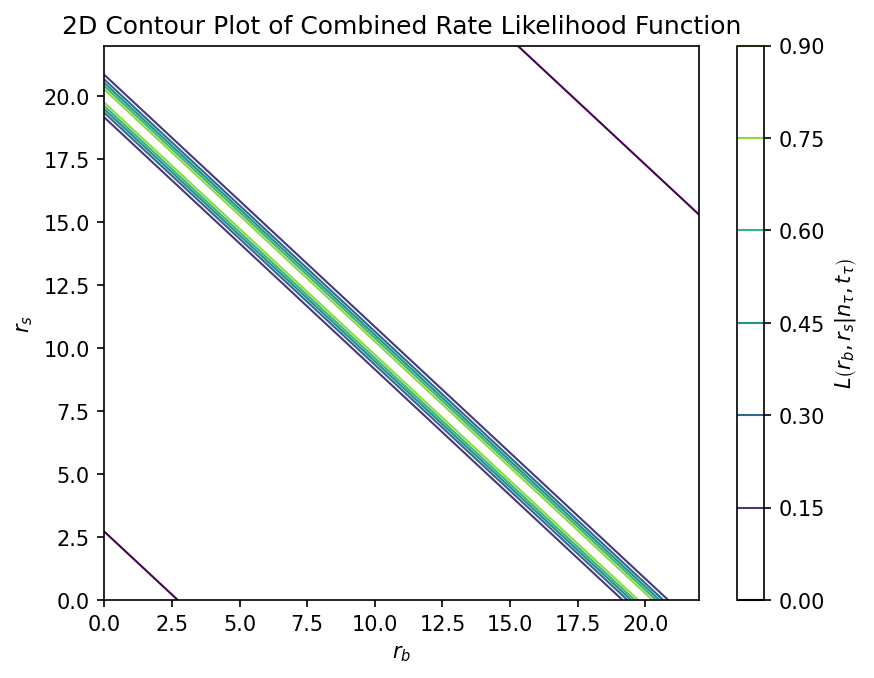

In [3]:
def total_rate_likelihood(r_b, r_s, n_tau, t_tau):
    if n_tau<200:
        print('Warning - likelihood only valid for large total counts, results may be inaccurate')
    return  t_tau*np.exp(-(n_tau - t_tau * (r_b + r_s)) ** 2 /(2 * n_tau)) / np.sqrt(2 * np.pi * n_tau)

if verbose:
    
    # Define lam_b_values, lam_s_values, and posterior_values
    counts = 2000
    time = 100
    
    r_b_values = np.linspace(0, 1.1*counts, 600)/time  # Example range for lam_b
    r_s_values = np.linspace(0, 1.1*counts, 600)/time  # Example range for lam_s
    
    # Create a grid of lam_b and lam_s values for contour plotting
    r_b_grid, r_s_grid = np.meshgrid(r_b_values, r_s_values)
    posterior_values = total_rate_likelihood(r_b_grid, r_s_grid, counts, time)  # Example n_t and n_b values
    
    
    # Create the contour plot
    plt.contour(r_b_grid, r_s_grid, posterior_values, linewidths=1, cmap='viridis')
    plt.xlabel('$r_b$')
    plt.ylabel('$r_s$')
    plt.title('2D Contour Plot of Combined Rate Likelihood Function')
    plt.colorbar(label=r'$L\left( r_b, r_s | n_\tau , t_\tau \right)$')
    plt.show()
    

It is no surprise that argmax $L$ is at $r_b +r_s = n_\tau /t$.  The maximum likelihood estimate does not have enough information to constrain our signal rate.  To resolve this issue we can take a measurement of the background with the reactor off and assign a prior to our likelihood function. 

Here we will assume our prior is just the (normalized) likelihood function we would use to estimate the background rate $r_b$ given our background measurement $n_b$ and background measurement time $t_b$:

$$p\left( r_b | n_b ,t_b \right) \approx \frac{t_b}{\sqrt{2\pi n_b}}\exp{\left(-\frac{(n_b-t_b r_b)^2}{2n_b}\right)}$$ 

We can then use Bayes' theorem to calculate the posterior probability of our signal rate given our observed counts $n_t$ and our background measurement $n_b$:

$$\frac{p\left( r_b | n_b \right) L\left( r_b, r_s | n_\tau, t_\tau\right)}{p(n_b,n_\tau)} = \frac{t_b t_\tau}{2\pi \sqrt{n_b n_\tau}} \exp{\left(-\frac{(n_b-t_b r_b)^2}{2n_b}-\frac{(n_\tau - t_\tau(r_b+r_s))^2}{2n_\tau}\right)}$$ 

Note: $n_b$ is a separate measurement from $n_\tau$ and backgrounds are assumed to be unaffected by reactor operation.


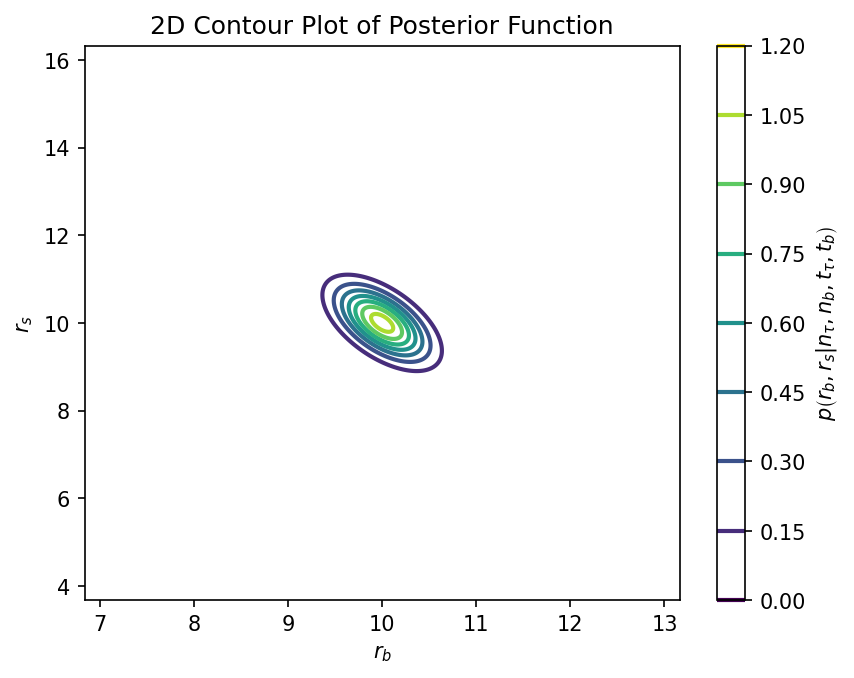

In [4]:

def total_rate_posterior(r_b, r_s, n_tau, n_b , t_tau, t_b):
    return rate_likelihood(r_b, n_b, t_b) * total_rate_likelihood(r_b, r_s, n_tau, t_tau)

def total_rate_posterior_norm(n_tau, n_b, t_tau, t_b):
    # Define the integrand for normalization
    integrand = lambda r_s, r_b: total_rate_posterior(r_b, r_s, n_tau, n_b, t_tau, t_b)
    
    # Set the integration bounds for r_b and r_s
    r_b_lower_bound = (n_b - 10 * np.sqrt(n_b)) / t_b
    r_b_upper_bound = (n_b + 10 * np.sqrt(n_b)) / t_b
    r_s_lower_bound = n_tau/t_tau - n_b/t_b - 10 * np.sqrt(n_tau - n_b) / t_tau - 10 * np.sqrt(n_b) / t_b
    r_s_upper_bound = (n_tau - n_b*t_tau/t_b + 10 * np.sqrt(n_tau - n_b)) / t_tau + 10 * np.sqrt(n_b) / t_b
    
    # Perform the double integration to calculate the normalization constant
    normalization_constant, err = integrate.dblquad(integrand, r_b_lower_bound, r_b_upper_bound,
                                                  r_s_lower_bound, r_s_upper_bound,
                                                  epsabs=1e-15, epsrel=1e-15)
    print(normalization_constant, err)
    return normalization_constant

def normalized_total_rate_posterior(r_b, r_s, n_tau, n_b, t_tau, t_b):
    # Define the integrand for normalization
    normalization_constant = total_rate_posterior_norm(n_tau, n_b, t_tau, t_b)
    
    # Perform the double integration to calculate the normalization constant
    return 1/normalization_constant * total_rate_posterior(r_b, r_s, n_tau, n_b, t_tau, t_b)
verbose=True
if verbose:
    n_tau = 2000
    n_b = 1000
    
    t_tau = 100
    t_b = 100

    r_b_lower_bound = (n_b - 10 * np.sqrt(n_b)) / t_b
    r_b_upper_bound = (n_b + 10 * np.sqrt(n_b)) / t_b
    r_s_lower_bound = n_tau/t_tau - n_b/t_b - 10 * np.sqrt(n_tau - n_b) / t_tau - 10 * np.sqrt(n_b) / t_b 
    r_s_upper_bound = (n_tau - n_b*t_tau/t_b + 10 * np.sqrt(n_tau - n_b)) / t_tau + 10 * np.sqrt(n_b) / t_b
    r_b_values = np.linspace( r_b_lower_bound,r_b_upper_bound,1000) # Example range for lam_b
    r_s_values = np.linspace(r_s_lower_bound, r_s_upper_bound, 1000)  # Example range for lam_s
    
    r_b_grid, r_s_grid = np.meshgrid(r_b_values, r_s_values)
    posterior_values = total_rate_posterior(r_b_grid, r_s_grid, n_tau, n_b, t_tau, t_b)  # Example n_t and n_b values

    # Create the contour plot using matplotlib
    plt.contour(r_b_values, r_s_values, posterior_values, cmap='viridis', linewidths=2)
    plt.xlabel('$r_b$')
    plt.ylabel('$r_s$')
    plt.title('2D Contour Plot of Posterior Function')
    plt.colorbar(label=r'$p\left( r_b, r_s | n_\tau, n_b, t_\tau, t_b \right)$')
    plt.show()




Very cool.  

As a recap we supply fixed observational parameters

* $n_\tau = $ number of observations with reactor on (signal + background)
* $n_b = $ number of observations with reactor off (background only)
* $t_\tau = $ time of observation with reactor on
* $t_b = $ time of observation with reactor off

and scan over the unknowns

* $r_b = $ background rate
* $r_s = $ signal rate

Now the last thing to do is get rid of the $r_b$ dependence in the posterior.  We can do this by integrating over $r_b$ to get the marginal posterior for $r_s$:

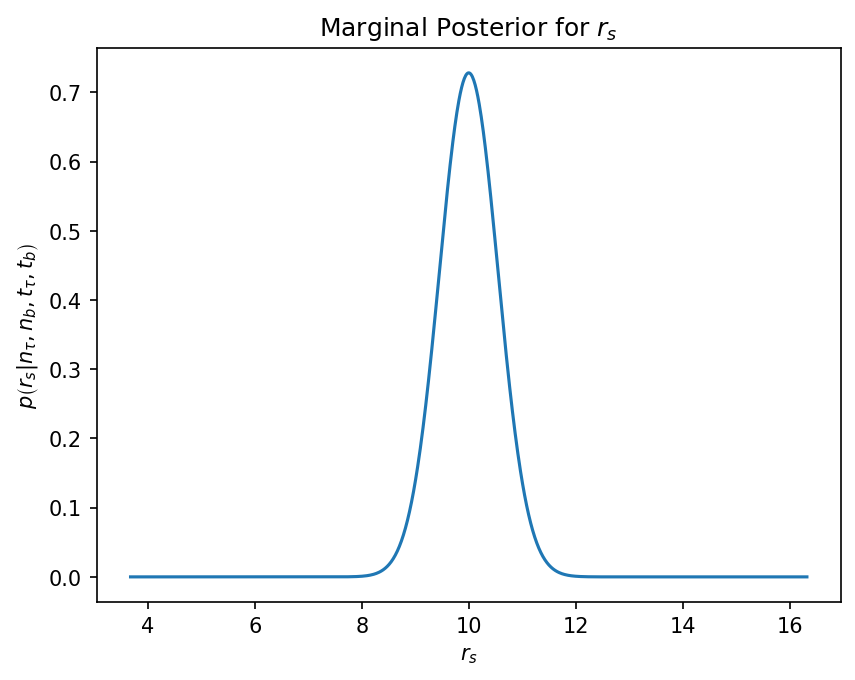

0.9999999999999989


In [5]:
def rate_posterior(r_s_values, n_tau, n_b, t_tau, t_b):
    # will have to do a better job for this in the future if we are interested in the tails of the distribution
    r_b_values = np.linspace((n_b - 8*np.sqrt(n_b)), n_b + 8*np.sqrt(n_b), 3000)/t_b  # Example range for lam_b
    
    r_b_grid, r_s_grid = np.meshgrid(r_b_values, r_s_values)
    posterior_values = total_rate_posterior(r_b_grid, r_s_grid, n_tau, n_b, t_tau, t_b)  # Example n_t and n_b values

    rate_probability=np.trapz(posterior_values, r_b_values, axis=1)

    return rate_probability

if verbose:
    post=rate_posterior(r_s_values,n_tau, n_b, t_tau, t_b)
    plt.plot(r_s_values, post)
    plt.title(f'Marginal Posterior for $r_s$')
    plt.xlabel(f'$r_s$')
    plt.ylabel(f'$p\left( r_s | n_\\tau, n_b, t_\\tau, t_b \\right)$')
    plt.show()
    
    print(np.trapz(post, r_s_values))

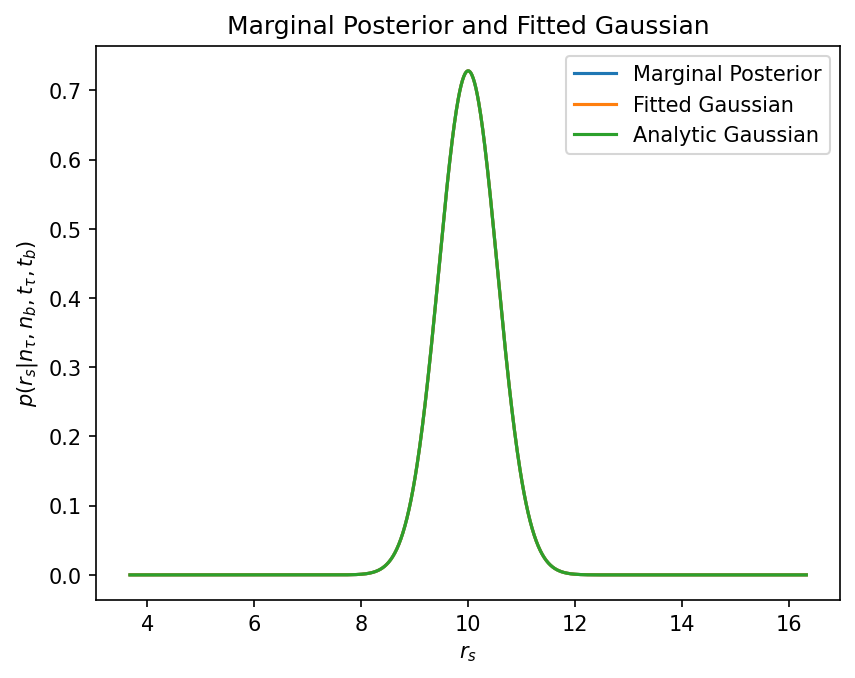

In [6]:
from scipy.stats import norm
from scipy.optimize import curve_fit

def simple_rate_posterior(r_s_values, n_tau, n_b, t_tau, t_b):
    return 1/np.sqrt(2*np.pi*(n_tau/t_tau**2+n_b/t_b**2))*np.exp(-(r_s_values-(n_tau/t_tau-n_b/t_b))**2/(2*(n_tau/t_tau**2+n_b/t_b**2)))

# Function to fit a Gaussian
def gaussian_fit(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

# Fitting a Gaussian to the marginal posterior
popt, _ = curve_fit(gaussian_fit, r_s_values, post, p0=[np.mean(r_s_values), np.std(r_s_values)])

if verbose:
    # Plotting the marginal posterior and the fitted Gaussian
    plt.plot(r_s_values, post, label='Marginal Posterior')
    plt.plot(r_s_values, gaussian_fit(r_s_values, *popt), label='Fitted Gaussian')
    plt.plot(r_s_values, simple_rate_posterior(r_s_values,n_tau, n_b, t_tau, t_b), label='Analytic Gaussian')
    
    plt.title('Marginal Posterior and Fitted Gaussian')
    plt.xlabel('$r_s$')
    plt.ylabel('$p(r_s | n_\\tau, n_b, t_\\tau, t_b)$')
    plt.legend()
    plt.show()

In [7]:
print("fit sigma =",popt[1])
print("analytic sigma =",np.sqrt(n_tau/t_tau**2+n_b/t_b**2))



fit sigma = 0.5477225575051661
analytic sigma = 0.5477225575051662



Sigh...all of that to re-derive the fact that you add these 'errors' in quadrature.  The marginal posterior is therefore

$$p\left(r_s | n_\tau, n_b, t_\tau, t_b \right) = \frac
{1}{\sqrt
{2\pi \sigma ^ 2}}\exp
{\left(-\frac
{(r_s -\mu) ^ 2}
{2\sigma ^ 2}\right)}$$

where 
$\mu = \frac{n_\tau}{t_\tau} - \frac{n_b}{t_b}$ which is what you would intuitively guess / expect the answer to be and 
$\sigma = \sqrt{\frac{n_\tau}{t_\tau^2} + \frac{n_b}{t_b^2}}$ adding the errors in quadrature.

Cleaning everything up we get:


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def rate_likelihood(rate, n, time):
    if n < 100:
        return time * (rate * time) ** n * np.exp(-(rate * time)) / math.factorial(n)
    else:
        return time * np.exp(-(n - (rate * time)) ** 2 / (2 * n)) / np.sqrt(2 * np.pi * n)

def total_rate_likelihood(r_b, r_s, n_tau, t_tau):
    return t_tau * np.exp(-(n_tau - t_tau * (r_b + r_s)) ** 2 / (2 * n_tau)) / np.sqrt(2 * np.pi * n_tau)

def total_rate_posterior(r_b, r_s, n_tau, n_b, t_tau, t_b):
    return rate_likelihood(r_b, n_b, t_b) * total_rate_likelihood(r_b, r_s, n_tau, t_tau)

def rate_posterior(r_s_values, n_tau, n_b, t_tau, t_b):
    return 1/np.sqrt(2*np.pi*(n_tau/t_tau**2+n_b/t_b**2))*np.exp(-(r_s_values-(n_tau/t_tau-n_b/t_b))**2/(2*(n_tau/t_tau**2+n_b/t_b**2)))



Let us use this to understand expected error bars on the signal rate.  We will take guesses at what we think the rates and how long we will be measuring (with added parameter to understand how much a fancy background rejection algorithm may help our measurement) and see roughly how well we can do.  


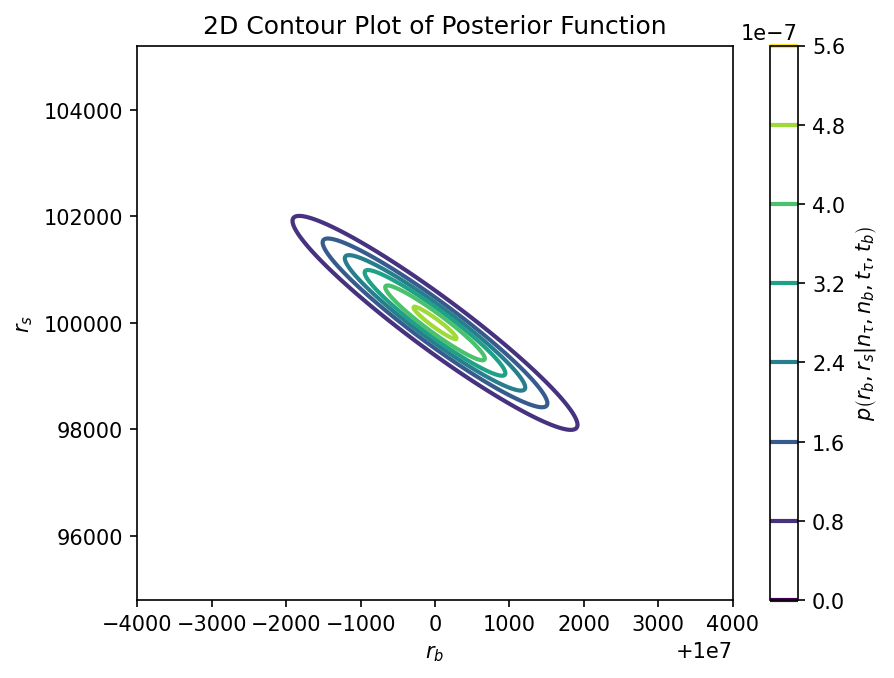

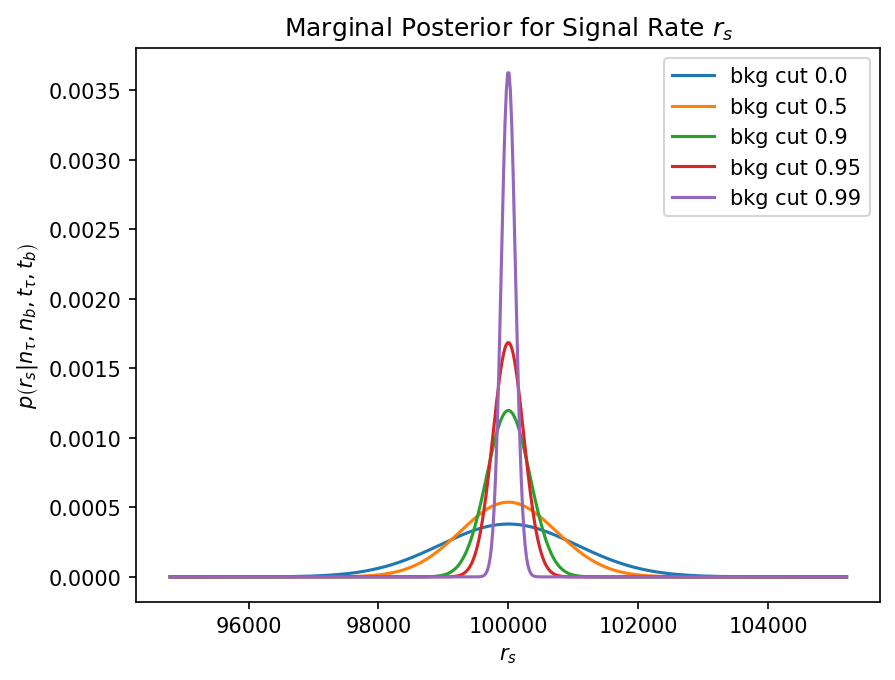

In [9]:
# Assume values
t_tau, t_b = 100, 10
r_signal, r_b = 1e5, 1e7
cut_background = np.array([0.00, 0.50, 0.90, 0.95, 0.99])

n_tau = t_tau * (r_signal + r_b)
n_b = t_b * r_b

r_b_lower_bound = (n_b - 4 * np.sqrt(n_b)) / t_b
r_b_upper_bound = (n_b + 4 * np.sqrt(n_b)) / t_b
r_s_lower_bound = n_tau / t_tau - n_b / t_b - 4 * np.sqrt(n_tau - n_b) / t_tau - 4 * np.sqrt(n_b) / t_b
r_s_upper_bound = (n_tau - n_b * t_tau / t_b + 4 * np.sqrt(n_tau - n_b)) / t_tau + 4 * np.sqrt(n_b) / t_b

r_b_values = np.linspace(r_b_lower_bound, r_b_upper_bound, 500)
r_s_values = np.linspace(r_s_lower_bound, r_s_upper_bound, 500)

r_b_grid, r_s_grid = np.meshgrid(r_b_values, r_s_values)
posterior_values = total_rate_posterior(r_b_grid, r_s_grid, n_tau, n_b, t_tau, t_b)

plt.contour(r_b_values, r_s_values, posterior_values, cmap='viridis', linewidths=2)
plt.xlabel('$r_b$')
plt.ylabel('$r_s$')
plt.title('2D Contour Plot of Posterior Function')
plt.colorbar(label=r'$p\left( r_b, r_s | n_\tau, n_b, t_\tau, t_b \right)$')
plt.show()

for cut in cut_background:
    
    n_tau = t_tau*(r_signal+r_b*(1-cut)) # number of observations with reactor on (signal + background)
    n_b = t_b*r_b*(1-cut) # number of observations with reactor off (background only)assuming we remove the easy stuff like throughgoing muons 
    post=rate_posterior(r_s_values,n_tau, n_b, t_tau, t_b)
    plt.plot(r_s_values, post, label=f'bkg cut {cut}')
plt.title(f'Marginal Posterior for Signal Rate $r_s$')
plt.xlabel(f'$r_s$')
plt.ylabel(f'$p\left( r_s | n_\\tau, n_b, t_\\tau, t_b \\right)$')
plt.legend()
plt.show()